## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Calculate Camera Calibration Parameters

In [307]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

CALIB_PARAMS='calibrate.b'
def get_camcal_parameters():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        print(fname)
        img = cv2.imread(fname)
        #print(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        print(ret)
        #plt.imshow(img)
        #plt.show()
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)

            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints,imgpoints


In [309]:
import matplotlib.image as mpimg
def calc_mtx_dist(img,objpoints,imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #img=img[:,:,-1]
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=30)
    #ax2.imshow(dst)
    #ax2.set_title('Undistorted Image', fontsize=30)
    #plt.show()
    return mtx,dist,undst

def calc_calibrate_info():
    objpoints,imgpoints=get_camcal_parameters()
    img = mpimg.imread('camera_cal/calibration1.jpg')
    mtx,dist,undist=calc_mtx_dist(img,objpoints,imgpoints)
    calib_data = {'mtx':mtx,
                  'dist':dist}
    with open(CALIB_PARAMS, 'wb') as f:
        pickle.dump(calib_data, f)

calc_calibrate_info()        

camera_cal/calibration1.jpg
False
camera_cal/calibration10.jpg
True
camera_cal/calibration11.jpg
True
camera_cal/calibration12.jpg
True
camera_cal/calibration13.jpg
True
camera_cal/calibration14.jpg
True
camera_cal/calibration15.jpg
True
camera_cal/calibration16.jpg
True
camera_cal/calibration17.jpg
True
camera_cal/calibration18.jpg
True
camera_cal/calibration19.jpg
True
camera_cal/calibration2.jpg
True
camera_cal/calibration20.jpg
True
camera_cal/calibration3.jpg
True
camera_cal/calibration4.jpg
False
camera_cal/calibration5.jpg
False
camera_cal/calibration6.jpg
True
camera_cal/calibration7.jpg
True
camera_cal/calibration8.jpg
True
camera_cal/calibration9.jpg
True


## Use Camera Calibration Data to correct to raw images.

In [106]:
import cv2
import pickle
import numpy as np
import matplotlib.image as mpimg

CALIB_PARAMS='calibrate.b'

with open(CALIB_PARAMS, 'rb') as f:
    calib_data = pickle.load(f)
mtx = calib_data["mtx"]
dist = calib_data["dist"]
def undistort_img(img,mtx,dist):
    return  cv2.undistort(img, mtx, dist, None, mtx)


In [107]:
def test_undist_img(distorted_images):
    for filename in distorted_images:
        print(filename)
        img = mpimg.imread(filename)
        undist=undistort_img(img,mtx,dist)
        paths=filename.split('/')
        paths[-1]='undistort_'+paths[-1]
        undistort_filename='/'.join(paths)
        undistort_filename=undistort_filename.replace('test_images','output_images')
        cv2.imwrite(undistort_filename , undist)
        f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
        f.set_size_inches([15., 4.])
        ax1.imshow(img)
        ax2.imshow(undist)

In [108]:
distorted_images = glob.glob('test_images/*.jpg')
test_undist_img(distorted_images)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


## Apply a perspective transform to rectify binary image ("birds-eye view"). 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

straight_line1_img=mpimg.imread('test_images/straight_lines1.jpg')   
plt.imshow(straight_line1_img)
plt.plot(229,600,'.')
plt.plot(1051,600,'.')
plt.plot(1180,666,'.')
plt.plot(100,666,'.')
plt.show()

In [126]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import copy

PERSPECTIVE_PARAMS='perspective.b'
def convert_bird_view(img):
    src= np.float32([[260,684],[609,441],[667,441],[1035,677]])
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
          [[229,600],
           [1051,600],
           [1180,666],
           [100,666]])
    
    dst = np.float32(
          [[img.shape[1]*0  ,img.shape[0]*0.9],
           [img.shape[1]*1  ,img.shape[0]*0.9],
           [img.shape[1]*1  ,img.shape[0]*1  ],
           [img.shape[1]*0  ,img.shape[0]*1  ]])

    #src=np.float32([[375,479],[905,479],[1811,685],[-531,685]])
    #dst=np.float32([[0,0],[500,0],[500,600],[0,600]])

    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    return M,MInv

def calc_perspective_transform():
    img=mpimg.imread('test_images/straight_lines1.jpg')                 
    M,MInv=convert_bird_view(img)
    perspective_tranform = {'M':M,'MInv':MInv}
    with open(PERSPECTIVE_PARAMS, 'wb') as f:
        pickle.dump(perspective_tranform, f)
    return M,MInv

M,MInv=calc_perspective_transform()

def perspective_transform(img,M):
    img_size=(img.shape[1],img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img

def deperspective_transform(warped_img,MInv):
    img_size=(img.shape[1],img.shape[0])
    warped_img_inv = cv2.warpPerspective(warped_img, MInv, img_size)
    return warped_img_inv

In [137]:
def test_perspective_transform(test_filenames):
    for filenmae in test_filenames:
        img=mpimg.imread(filenmae)    
        plt.imshow(img)
        plt.show()

    for filename in test_filenames:
        img=mpimg.imread(filename)    
        img_warp = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
        img_warp_inv =  cv2.warpPerspective(img, MInv, (img.shape[1],img.shape[0]))
        paths=filename.split('/')

        pt_paths=copy.copy(paths)
        ptinv_paths=copy.copy(paths)
        pt_paths[-1]='pt_'+pt_paths[-1]
        pt_filename='/'.join(pt_paths)
        pt_filename=pt_filename.replace('test_images','output_images')
        cv2.imwrite(pt_filename,img_warp)


        ptinv_paths[-1]='ptinv_'+ptinv_paths[-1]
        ptinv_filename='/'.join(ptinv_paths)
        ptinv_filename=ptinv_filename.replace('test_images','output_images')
        ptinv_filename='/'.join(ptinv_paths) 
        print('inv file name',ptinv_filename)
        cv2.imwrite(ptinv_filename,img_warp_inv)

        f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
        f.set_size_inches([15., 4.])
        ax1.imshow(img_warp)
        ax2.imshow(img_warp_inv)
    

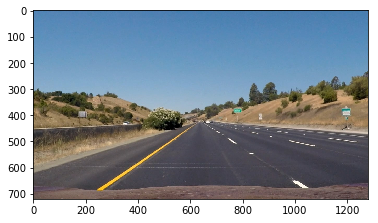

In [138]:
img=mpimg.imread('test_images/straight_lines1.jpg') 
straight_lines_1_warp =cv2.warpPerspective(img, M, (straight_line1_img.shape[1],straight_line1_img.shape[0]))
straight_lines_1_warp_inv = cv2.warpPerspective(straight_lines_1_warp, M, (straight_lines_1_warp.shape[1],straight_lines_1_warp.shape[0]))
plt.imshow(straight_line1_img)
plt.show()

f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches([15., 4.])
ax1.imshow(straight_lines_1_warp)
ax2.imshow(straight_lines_1_warp_inv)
    



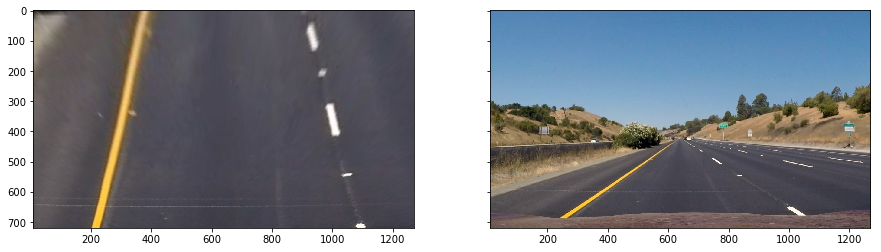

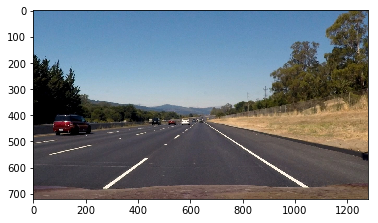

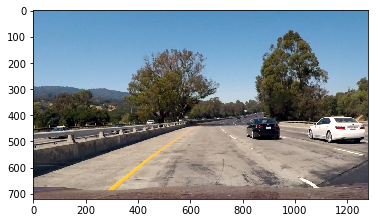

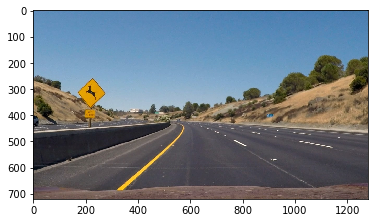

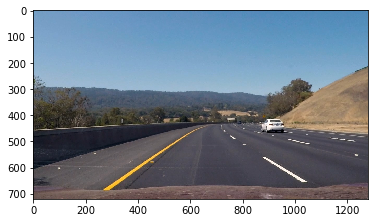

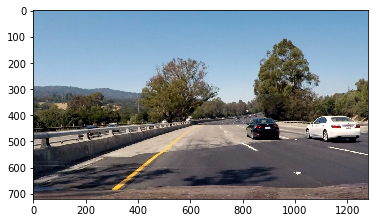

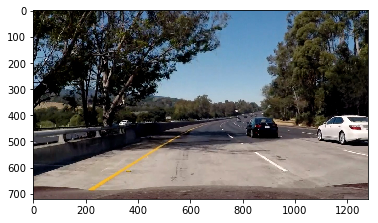

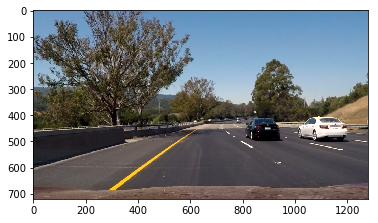

inv file name test_images/ptinv_straight_lines1.jpg
inv file name test_images/ptinv_straight_lines2.jpg
inv file name test_images/ptinv_test1.jpg
inv file name test_images/ptinv_test2.jpg
inv file name test_images/ptinv_test3.jpg
inv file name test_images/ptinv_test4.jpg
inv file name test_images/ptinv_test5.jpg
inv file name test_images/ptinv_test6.jpg


In [139]:
test_filenames = glob.glob('test_images/*.jpg')
test_perspective_transform(test_filenames)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [140]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob
import pickle
import matplotlib.pyplot as plt

PERSPECTIVE_PARAMS='perspective.b'
CALIB_PARAMS='calibrate.b'
def load_calibrate_paramters():
    with open(CALIB_PARAMS, 'rb') as f:
        calib_parameters = pickle.load(f)
    mtx = calib_parameters["mtx"]
    dist = calib_parameters["dist"]
    
    with open(PERSPECTIVE_PARAMS, 'rb') as f:
        perspective_parameters = pickle.load(f)
    M = perspective_parameters["M"]
    MInv = perspective_parameters["MInv"]
    return mtx,dist,M,MInv



def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

mtx,dist,M,MInv=load_calibrate_paramters()

In [ ]:
def test_perspective_transform_undist(image_filenames):
    for filename in image_filenames:
        print(filename)

        img = mpimg.imread(filename)
        undist=cv2.undistort(img, mtx, dist, None, mtx)
        bin_img=pipeline(undist)
        plt.imshow(bin_img,cmap='gray')
        plt.show()
    for filenmae in image_filenames:
        img=mpimg.imread(filenmae)    
        img_warp = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
        img_warp_inv =  cv2.warpPerspective(img_warp, MInv, (img.shape[1],img.shape[0]))
        f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
        f.set_size_inches([15., 4.])
        ax1.imshow(img_warp)
        binary_image=pipeline(img_warp,s_thresh=(255,0))

        ax2.imshow(img_warp_inv)
        plt.show()
    
    for filenmae in image_filenames:
        img=mpimg.imread(filenmae)    
        img_warp = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
        img_warp_inv =  cv2.warpPerspective(img_warp, MInv, (img.shape[1],img.shape[0]))


        dd = pipeline(img_warp_inv)
        color_warp = np.dstack((dd, dd, dd))
        result = cv2.addWeighted(img, 1, color_warp, 0.3, 0)
        plt.imshow(dd)
        plt.show()

test_images/ptinv_straight_lines1.jpg


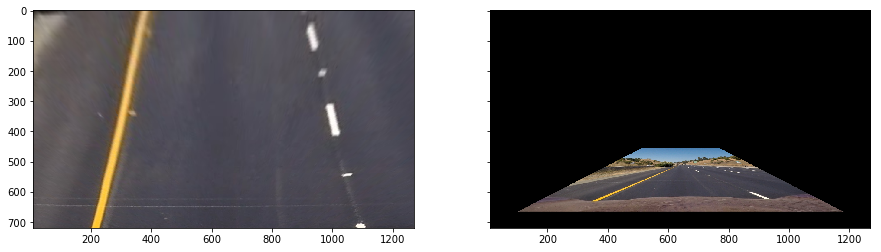

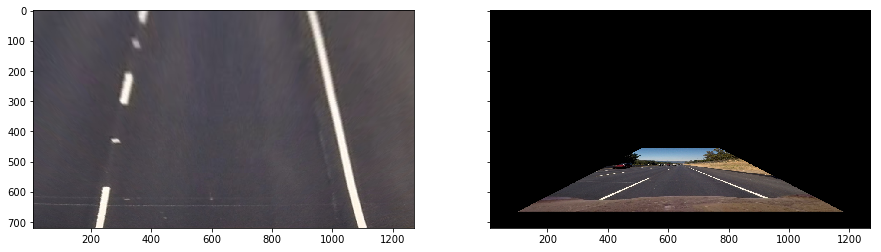

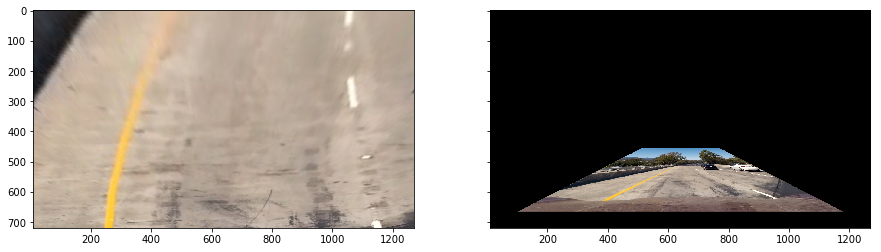

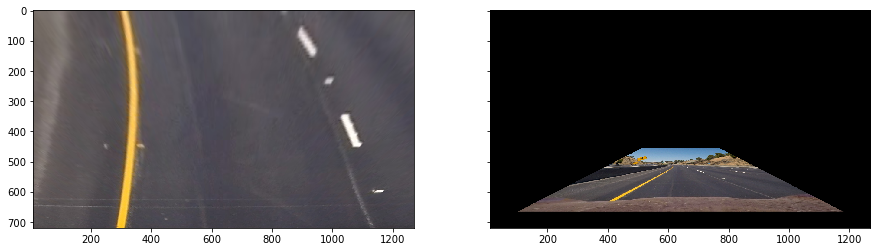

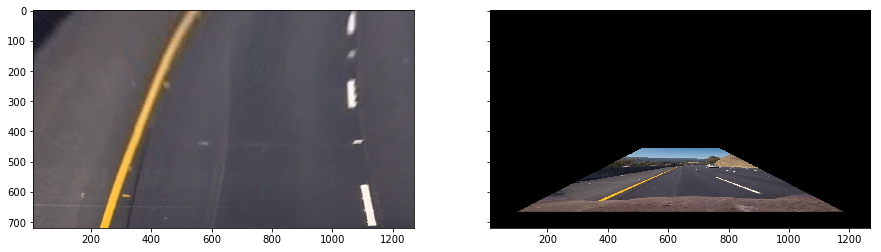

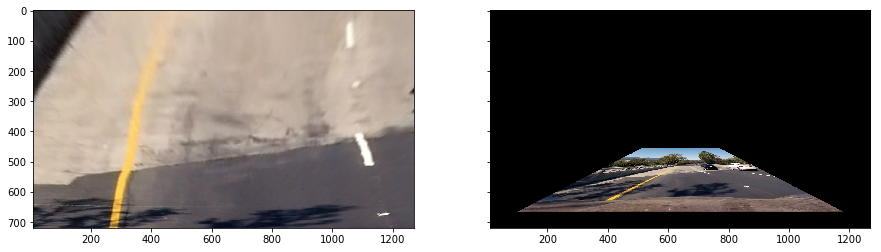

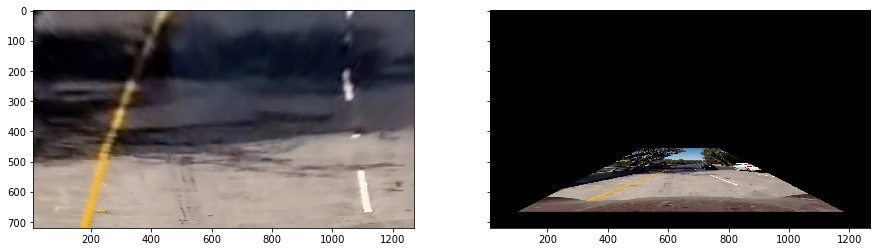

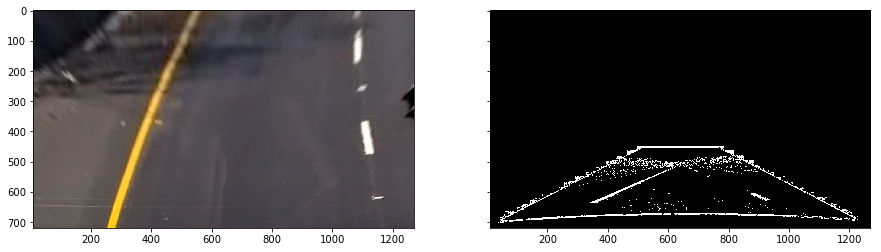

test_images/ptinv_straight_lines2.jpg


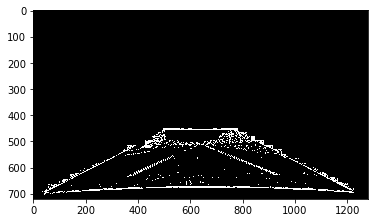

test_images/ptinv_test1.jpg


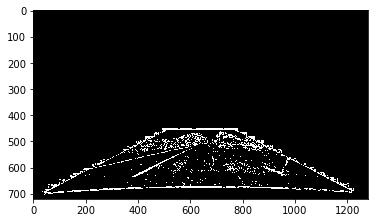

test_images/ptinv_test2.jpg


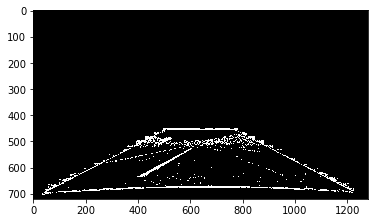

test_images/ptinv_test3.jpg


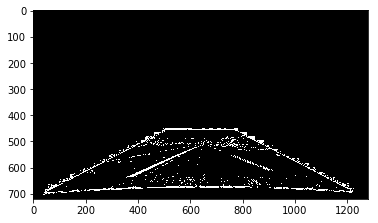

test_images/ptinv_test4.jpg


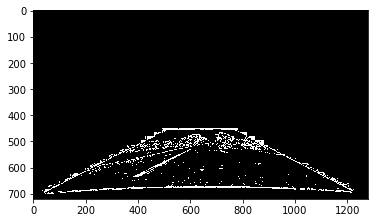

test_images/ptinv_test5.jpg


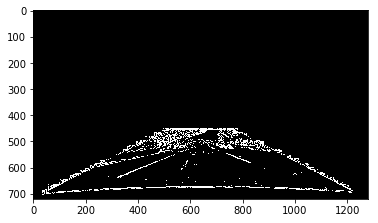

test_images/ptinv_test6.jpg


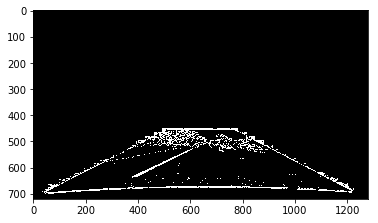

test_images/straight_lines1.jpg


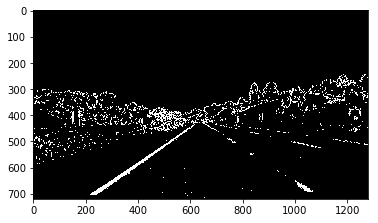

test_images/straight_lines2.jpg


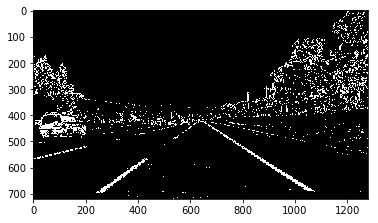

test_images/test1.jpg


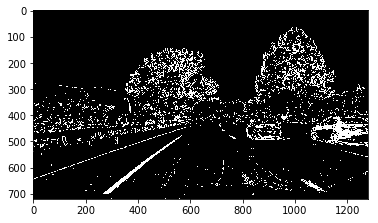

test_images/test2.jpg


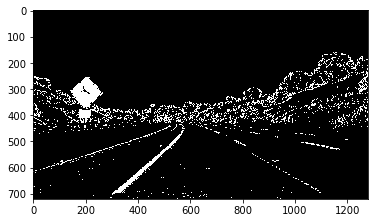

test_images/test3.jpg


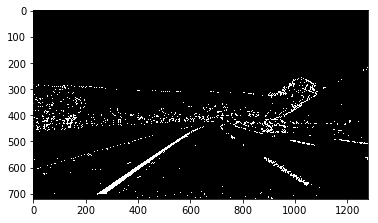

test_images/test4.jpg


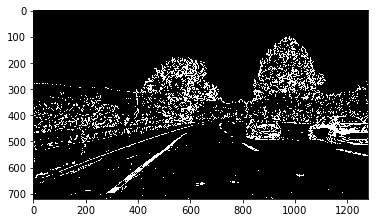

test_images/test5.jpg


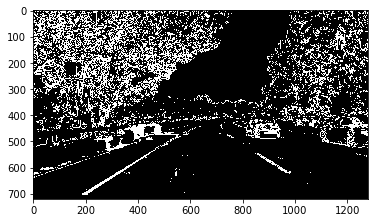

test_images/test6.jpg


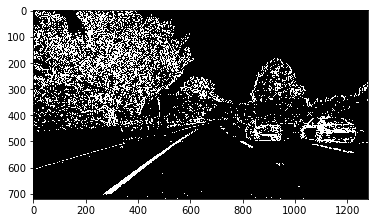

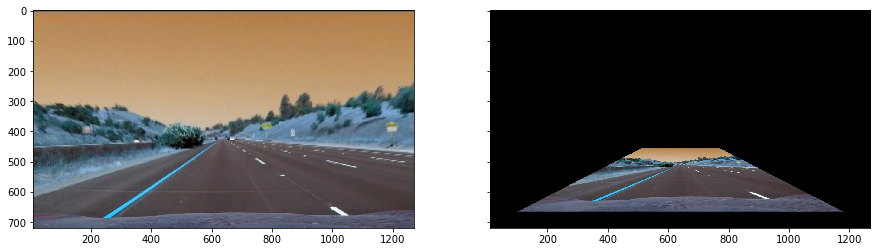

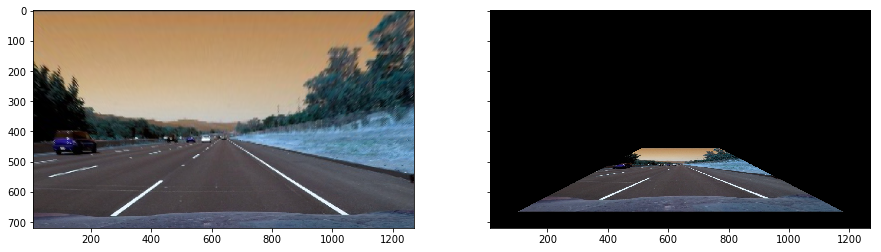

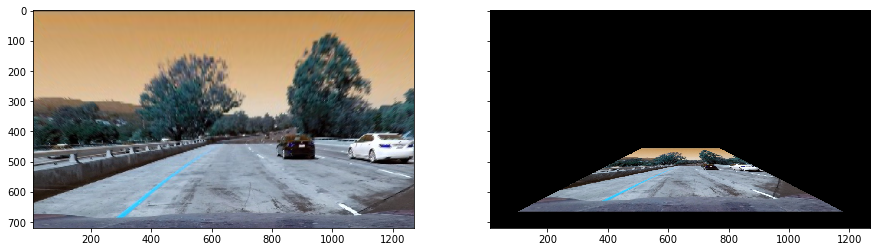

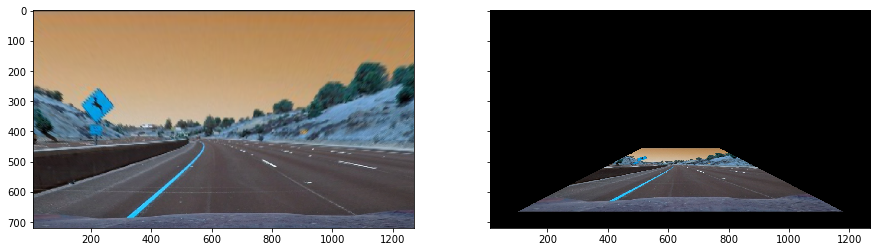

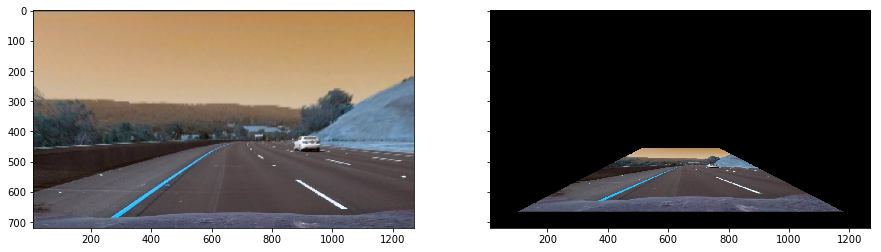

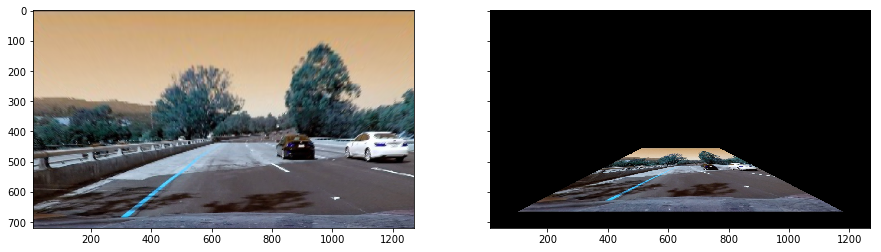

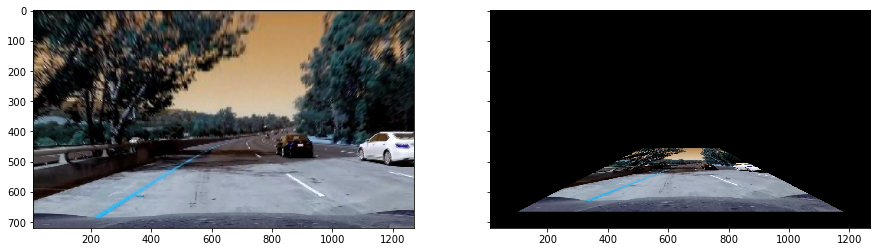

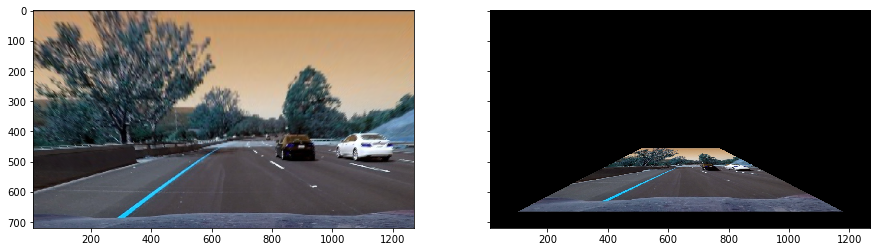

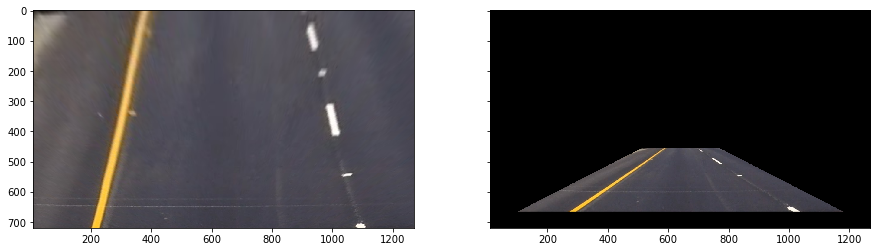

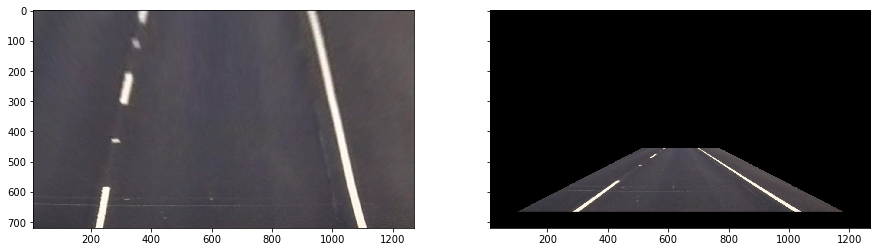

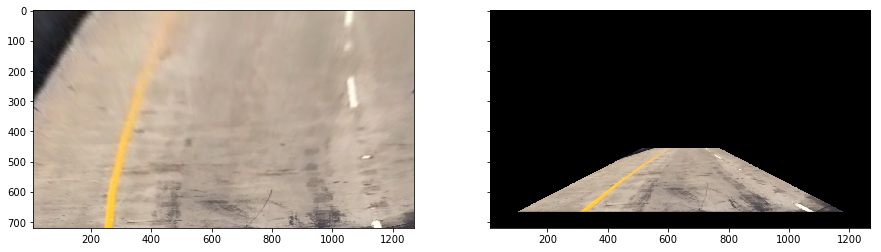

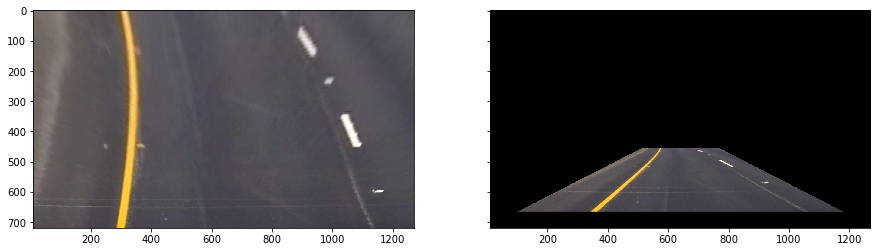

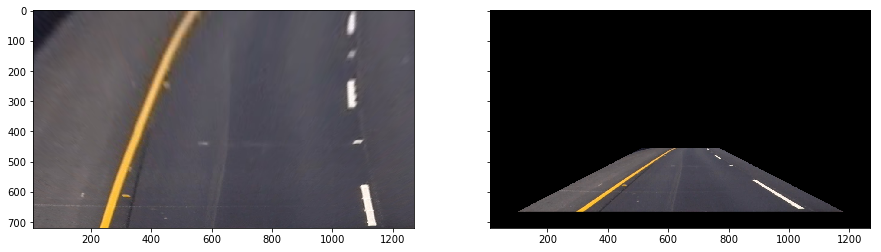

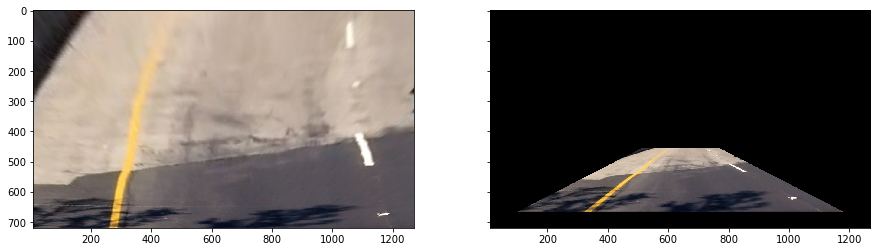

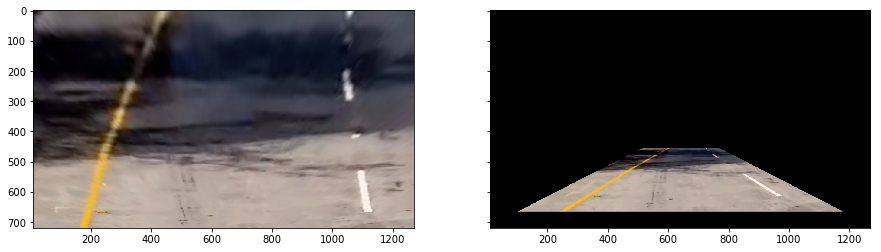

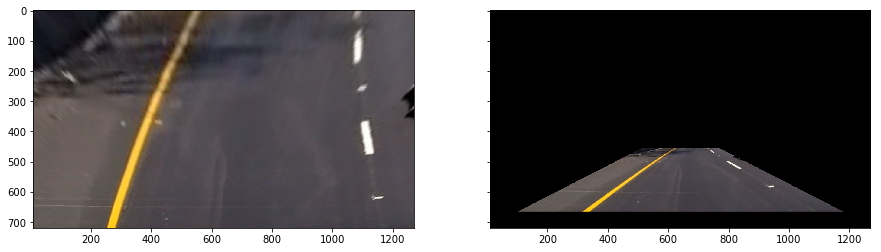

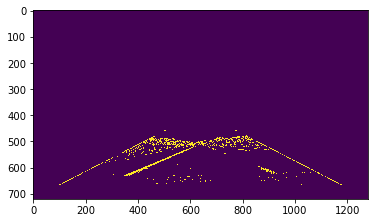

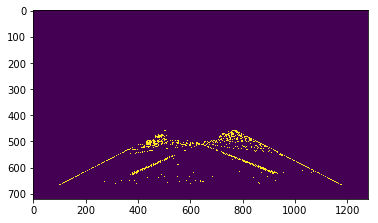

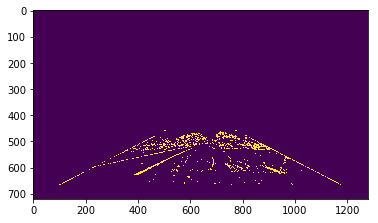

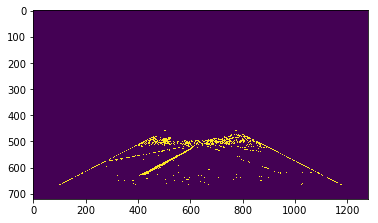

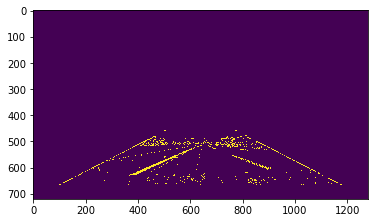

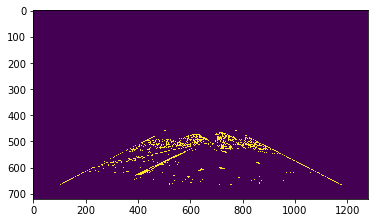

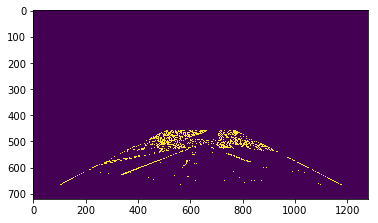

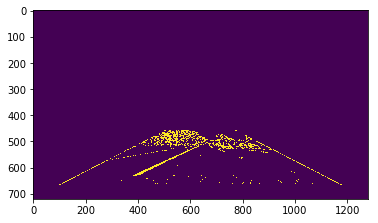

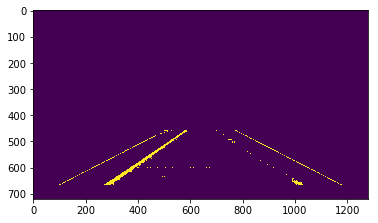

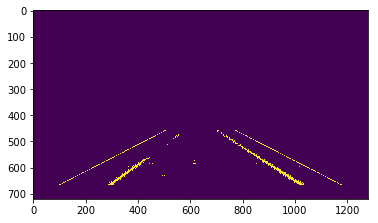

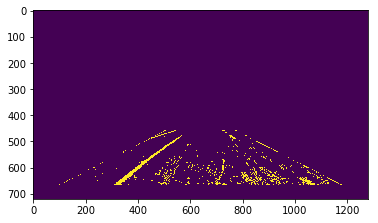

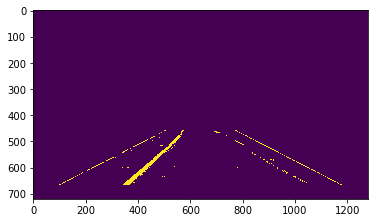

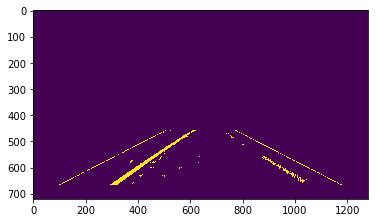

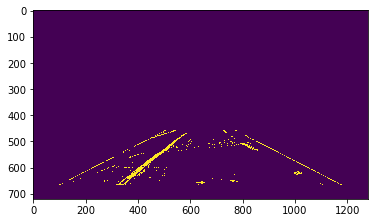

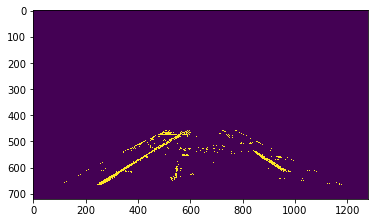

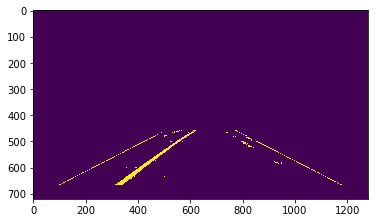

In [141]:
image_filenames = glob.glob('test_images/*.jpg')
test_perspective_transform_undist(image_filenames)

## Find starting point through histogram

In [85]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob
import pickle
import matplotlib.pyplot as plt
from collections import deque


PERSPECTIVE_PARAMS='perspective.b'
CALIB_PARAMS='calibrate.b'

QUEUE_LENGTH=7

left_fit_size=0
right_fit_size=0
right_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
left_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
def reset_fit_parametrs():
    global right_fit_size
    global left_fit_size
    global right_fit_history
    global left_fit_history
    right_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
    left_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
    left_fit_size=0
    right_fit_size=0
def load_calibrate_paramters():
    with open(CALIB_PARAMS, 'rb') as f:
        calib_parameters = pickle.load(f)
    mtx = calib_parameters["mtx"]
    dist = calib_parameters["dist"]
    
    with open(PERSPECTIVE_PARAMS, 'rb') as f:
        perspective_parameters = pickle.load(f)
    M = perspective_parameters["M"]
    MInv = perspective_parameters["MInv"]
    return mtx,dist,M,MInv

mtx,dist,M,MInv=load_calibrate_paramters()
def get_curve(left_fit, right_fit):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 719

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 9/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/980 # meters per pixel in x dimension
    
    # Transform
    right_fit_cr = ym_per_pix * np.array((right_fit[0]*xm_per_pix*xm_per_pix,right_fit[1]*xm_per_pix),right_fit[2])
    left_fit_cr = ym_per_pix * np.array((left_fit[0]*xm_per_pix*xm_per_pix,left_fit[1]*xm_per_pix),left_fit[2])
                               
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Calculate a polinomial value in a given point x

    left_pos = np.poly1d(left_fit)(720)
    right_pos = np.poly1d(right_fit)(720)
    #print(left_pos,right_pos)
    center_pos = (left_pos + right_pos)/2
    #print(center_pos)
    center_offset = center_pos - (1280/2)
    #print(center_offset)
    center_offset_scalefactor = .00431 
    center_offset_m = center_offset * center_offset_scalefactor

    #print('center_offset_m===',center_offset_m)


    return left_curverad,right_curverad
    
    


def find_line(binary_warped,b_video=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    global left_fit
    global right_fit

    #left_fit = None
    #right_fit = None
    smoothing=0.75

    if not 'left_fit' in globals():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        #print('smoothing===',smoothing)
        #print('left_fit===',left_fit)
        ##print('lefty===',lefty)
        #print('leftx===',leftx)
        if len(lefty)>0 and len(leftx)>=0:
            left_fit = (smoothing)*left_fit   + ((1-smoothing)*np.polyfit(lefty, leftx, 2))
    
    if not 'right_fit' in globals():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = (smoothing)*right_fit + ((1-smoothing)*np.polyfit(righty, rightx, 2))


    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        pass
    if b_video:
        global right_fit_size
        global left_fit_size
        global right_fit_history
        global left_fit_history
        left_curve,right_curve=get_curve(left_fit,right_fit)
        if(left_curve>1600):
            left_fit_size=left_fit_size+1
            left_fit_history.append(left_fit)
        if(left_fit_size>=7):
            left_fit=np.mean(left_fit_history,axis=0)
        
        if(right_curve>1600):
            right_fit_size=right_fit_size+1
            right_fit_history.append(right_fit)
        if(right_fit_size>=7):
            right_fit=np.mean(right_fit_history,axis=0)
            #right_fit=right_fit_history[QUEUE_LENGTH-1]           
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin  *= 0.5
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 0,255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0,0))
    
    cv2.floodFill(image = window_img, seedPoint = (window_img.shape[1]//2-1,window_img.shape[0]-1), newVal=(0,255, 0), loDiff=(0, 0, 0, 0), upDiff=(0, 0, 0, 0), flags=4, mask=None)
    #print(left_fit)
    #print(right_fit)

    #plt.imshow(window_img)
    plt.show()
    return window_img,left_fit,right_fit


In [86]:

def calc_radius(img,left_fit, right_fit):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 719

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 9/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/980 # meters per pixel in x dimension
    
    # Transform
    right_fit_cr = ym_per_pix * np.array((right_fit[0]*xm_per_pix*xm_per_pix,right_fit[1]*xm_per_pix),right_fit[2])
    left_fit_cr = ym_per_pix * np.array((left_fit[0]*xm_per_pix*xm_per_pix,left_fit[1]*xm_per_pix),left_fit[2])
                               
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Calculate a polinomial value in a given point x

    left_pos = np.poly1d(left_fit)(720)
    right_pos = np.poly1d(right_fit)(720)
    #print(left_pos,right_pos)
    center_pos = (left_pos + right_pos)/2
    #print(center_pos)
    center_offset = center_pos - (1280/2)
    #print(center_offset)
    center_offset_scalefactor = .00431 
    center_offset_m = center_offset * center_offset_scalefactor

    #print('center_offset_m===',center_offset_m)
    #print('left_curverad=====',left_curverad )
    #print('right_curverad=====',right_curverad )

    #print(((left_curverad + right_curverad)/2))
    
    cv2.putText(img,'offset: %.2fm' % (center_offset_m),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.putText(img,'radius: %.2fm' % ((left_curverad + right_curverad)/2),(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
   




In [87]:



def merge_imgs(img,warped,left_fit,right_fit):
 
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warped, MInv, (warped.shape[1], warped.shape[0]))
    #newwarp[:newwarp.shape[0]//4,:,:] = 0
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    calc_radius(result,left_fit,right_fit)
    #plt.imshow(result)
    return result

  

In [88]:
window_width = 40 
window_height = 250 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

poly_left = []
poly_right = []

def get_curverad(coef, y):
    return ((1 + (2*coef[0]*y + coef[1])**2)**1.5) / np.abs(2*coef[0])

bVideo=False

def process_image(img):
    global poly_left
    global poly_right
    #plt.plot(img)
    #plt.show()
    img_size = (img.shape[1], img.shape[0])
    # Undistort image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M, img_size)
    b_warped=pipeline(warped)
    window_line,left_fit,right_fit=find_line(b_warped,bVideo)
    result=merge_imgs(img,window_line,left_fit,right_fit)
    return result,undistorted,warped,b_warped

In [89]:
bVideo=False
def test_find_lines(image_filenames):
    for filename in image_filenames:
        print(filename)

        img = mpimg.imread(filename)
        reset_fit_parametrs()
        processed_img=process_image(img)[0]
        plt.imshow(processed_img)
        plt.show()

test_images/straight_lines1.jpg


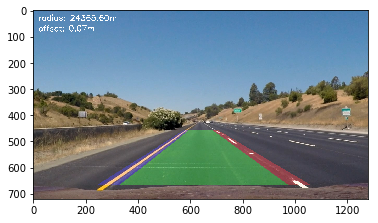

test_images/straight_lines2.jpg


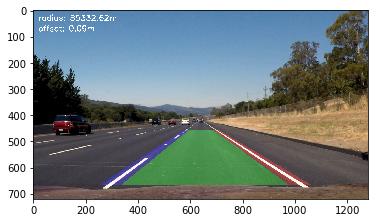

test_images/test1.jpg


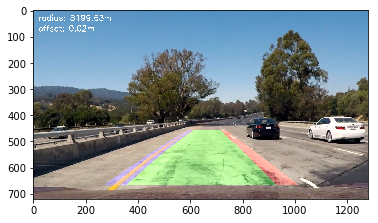

test_images/test2.jpg


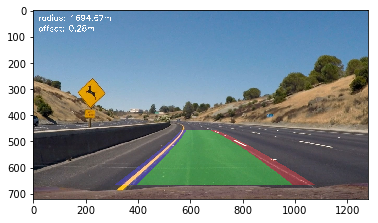

test_images/test3.jpg


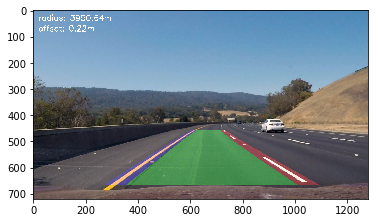

test_images/test4.jpg


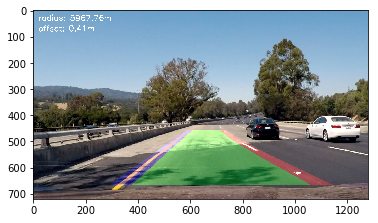

test_images/test5.jpg


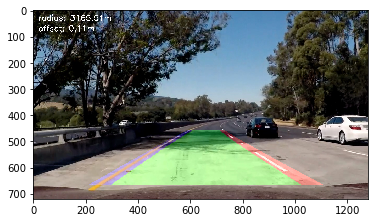

test_images/test6.jpg


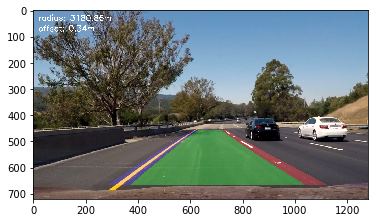

In [90]:
image_filenames = glob.glob('test_images/*.jpg')

test_find_lines(image_filenames)

# Run Against Testing Video

In [91]:
import imageio
imageio.plugins.ffmpeg.download()


In [92]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
bVideo=True
reset_fit_parametrs()
white_output = 'processed_video_project.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda img: process_image(img)[0])
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video processed_video_project.mp4
[MoviePy] Writing video processed_video_project.mp4



 20%|█▉        | 246/1261 [00:24<02:35,  6.54it/s]


 36%|███▋      | 459/1261 [00:50<01:43,  7.79it/s]


 54%|█████▎    | 677/1261 [01:18<01:54,  5.10it/s]


 72%|███████▏  | 913/1261 [01:46<00:46,  7.41it/s]


 91%|█████████ | 1150/1261 [02:12<00:10, 10.74it/s]


100%|█████████▉| 1260/1261 [02:23<00:00,  8.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video_project.mp4 

CPU times: user 2min 47s, sys: 28.5 s, total: 3min 15s
Wall time: 2min 23s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## And so on and so forth...